# Fitzhugh-Nagumo simplified action-potential model

This example shows how the [Fitzhugh-Nagumo simplified action potential (AP) model](http://pints.readthedocs.io/en/latest/toy/fitzhugh_nagumo_model.html) can be used.

The model is based on a simplification and state-reduction of the original squid axon model by Hodgkind and Huxley.
It has two state variables, a voltage-like variable and a recovery variable.


C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

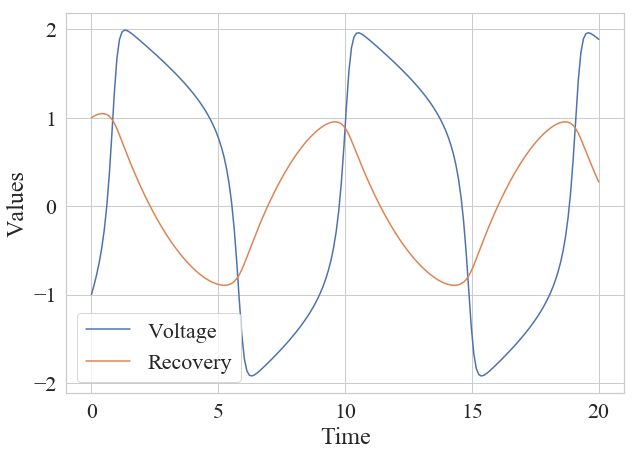

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=2, color_codes=True, rc={"grid.linewidth": 1})

# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
parameters = [0.1, 0.5, 3]
times = np.linspace(0, 20, 200)
values = model.simulate(parameters, times)

# Plot the results
fig = plt.figure(figsize=(10,7))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.legend(['Voltage', 'Recovery'])
plt.show()
fig.savefig("figures/nagumo.png", bbox_inches='tight', dpi=100)

With these parameters, the model creates wide AP waveforms that are more reminiscent of muscle cells than neurons.

We now set up a simple optimisation problem with the model.

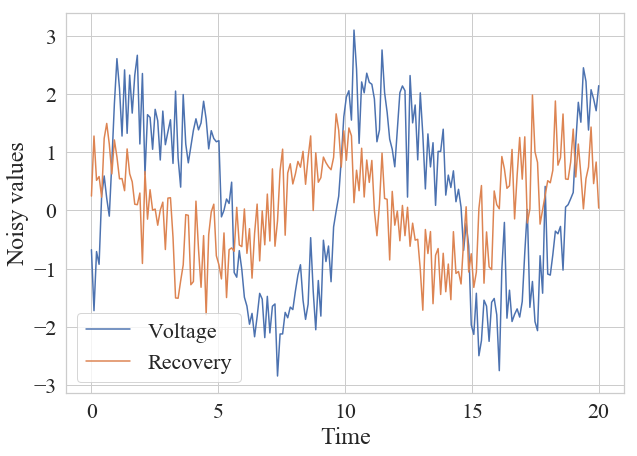

In [2]:
# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
fig = plt.figure(figsize=(10,7))
plt.xlabel('Time')
plt.ylabel('Noisy values')
plt.plot(times, noisy)
plt.legend(['Voltage', 'Recovery'])
plt.show()
fig.savefig("figures/nagumo_noisy.png", bbox_inches='tight', dpi=100)

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [3]:
problem = pints.MultiOutputProblem(model, times, noisy)
score = pints.SumOfSquaresError(problem)

Finally, we choose a wide set of boundaries and run!

In [4]:
# Select boundaries
boundaries = pints.RectangularBoundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries)

print('Score at true solution:')
print(score(parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(parameters[k]))

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      874.9436   0:00.1
1     14     751.2488   0:00.1
2     21     704.3899   0:00.1
3     28     704.3899   0:00.2
20    147    103.4741   0:01.0
40    287    100.0754   0:02.2
60    427    100.019    0:03.4
80    567    100.0187   0:04.5
100   707    100.0187   0:05.7
120   847    100.0187   0:07.2
140   987    100.0187   0:08.4
160   1127   100.0187   0:09.7
180   1267   100.0187   0:10.8
200   1407   100.0187   0:12.0
220   1547   100.0187   0:13.1
240   1687   100.0187   0:14.3
260   1827   100.0187   0:15.5
280   1967   100.0187   0:16.7
300   2107   100.0187   0:17.9
308   2156   100.0187   0:18.4
Halting: No significant change for 200 iterations.
Score at true solution:
101.37966551096983
Found solution:          True parameters:
 1.13832280480922893e-01     1.00000000000000006e-01
 3.76664396424800041e-01 

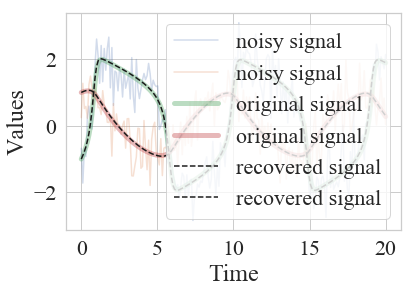

In [5]:
# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy, '-', alpha=0.25, label='noisy signal')
plt.plot(times, values, alpha=0.4, lw=5, label='original signal')
plt.plot(times, problem.evaluate(found_parameters), 'k--', label='recovered signal')
plt.legend()
plt.show()

This shows the parameters are not retrieved entirely correctly, but the traces still strongly overlap.

## Sampling with Monomial-gamma HMC

The Fitzhugh-Nagumo model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Monomial-gamma HMC.

In [ ]:
import time

problem = pints.MultiOutputProblem(model, times, noisy)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0],
    [10, 10, 10, 20, 20]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(parameters + [sigma, sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.5,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.MonomialGammaHamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(200)
mcmc.set_log_interval(1)

# Run in parallel
mcmc.set_parallel(True)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.05, 0.2, 0.2, 0.1, 0.1])
    sampler.set_leapfrog_steps(10)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time = end - start

Running...
Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in parallel with 4 worker processess.


c:\users\plagl\pints\pints\_mcmc\_monomial_gamma_hamiltonian.py:272: RuntimeWarning: overflow encountered in exp
  1.0 + np.exp(c * self._g(p, a, m)))


Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:10.8
1     44     0.333     0.333     0.333     0.333      0:12.2
2     84     0.5       0.5       0.5       0.5        0:13.0
3     124    0.6       0.6       0.6       0.6        0:13.8
4     164    0.667     0.667     0.667     0.667      0:14.6
5     204    0.714     0.714     0.714     0.714      0:15.5
6     244    0.75      0.75      0.75      0.625      0:16.2
7     284    0.778     0.778     0.778     0.556      0:17.0
8     324    0.8       0.8       0.8       0.5        0:17.8
9     364    0.818     0.818     0.818     0.455      0:18.8
10    404    0.833     0.833     0.833     0.417      0:19.7
11    444    0.846     0.846     0.846     0.462      0:20.5
12    484    0.857     0.857     0.857     0.5        0:21.4
13    524    0.867     0.867     0.867     0.533      0:22.3
14    564    0.875     0.875     0.875     0.5625     0:23.2
15    604    0.882     0

134   5364   0.985     0.978     0.978     0.934      2:35.3
135   5404   0.985     0.978     0.978     0.934      2:36.2
136   5444   0.986     0.978     0.978     0.935      2:37.2
137   5484   0.986     0.978     0.978     0.935      2:38.1
138   5524   0.986     0.979     0.979     0.936      2:39.3
139   5564   0.986     0.979     0.979     0.936      2:40.2
140   5604   0.986     0.979     0.979     0.937      2:41.1
141   5644   0.986014  0.979021  0.979021  0.937      2:42.1
142   5684   0.986     0.979     0.972     0.9375     2:43.0
143   5724   0.986     0.979     0.972     0.937931   2:43.9
144   5764   0.986     0.979     0.973     0.938      2:44.9
145   5804   0.986     0.98      0.973     0.939      2:45.9
146   5844   0.986     0.98      0.972973  0.939      2:46.8
147   5884   0.987     0.98      0.973     0.94       2:47.9
148   5924   0.987     0.98      0.973     0.94       2:48.9
149   5964   0.986755  0.98      0.974     0.94       2:50.4
150   6004   0.987     0

In [ ]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Print results.

In [ ]:
results = pints.MCMCSummary(chains=chains, time=time, parameter_names=["a", "b", "c", "sigma_V", "sigma_R"])
print(results)

Plot the few posterior predictive simulations versus data.

In [ ]:
import pints.plot
pints.plot.series(np.vstack(chains), problem)
plt.show()